In [69]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
import h5py as h5

In [3]:
# Read in solar irradiance:
file_irrad = '/Volumes/data1/ftp/XYZT_ESE156/TROPOMI/S5P_OFFL_L1B_IR_UVN_20181011T223825_20181012T001955_05158_01_010000_20181012T020852 2.h5'
fI = h5.File(file_irrad)

In [8]:
wl_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
spec_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/OBSERVATIONS/irradiance'][0,0,:,:]

In [9]:
spec_solar.shape

(450, 497)

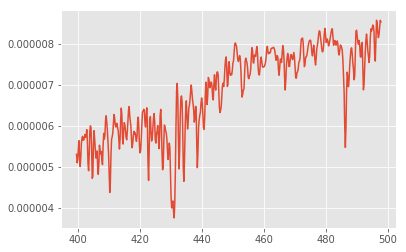

In [14]:
# Plot solar spectrum for specific footprint (imaging spectrometer!) 
fp = 100
plt.plot(wl_solar[fp,:], spec_solar[fp,:])

In [15]:
# Read in real data:
file_nadir = '/Volumes/data1/ftp/XYZT_ESE156/TROPOMI/S5P_OFFL_L1B_RA_BD4_20181011T223825_20181012T001955_05158_01_010000_20181012T020852.zip'
fn = h5.File(file_nadir)

In [23]:
lat = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
lon = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
sza = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]

In [24]:
wl_spec = fn['BAND4_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:,:]
spec = fn['BAND4_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]

(405, 465)

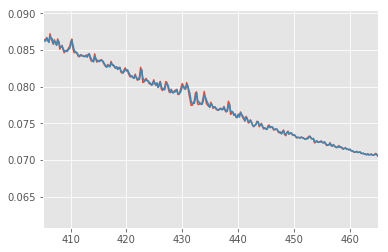

In [52]:
so = 1500
plt.plot(wl_spec[fp,:], spec[so,fp,:]/spl(wl_solar[fp,:]+0.0))
plt.plot(wl_spec[fp,:], spec[so,fp,:]/spl(wl_spec[fp,:]-0.018))
plt.xlim((405,465))

In [27]:
wl_spec.shape

(450, 497)

In [33]:
from scipy.interpolate import UnivariateSpline

In [34]:
spl = UnivariateSpline(wl_solar[fp,:], spec_solar[fp,:], k=3, s=0)

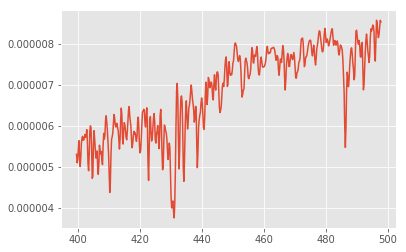

In [54]:
plt.plot(wl_solar[fp,:],spec_solar[fp,:])

In [56]:
from urllib.request import urlopen
file_o3 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/TROPOMI/crossSections/O3_Serdyuchenko(2014)_243K_213-1100nm(2012 version).txt")
file_no2 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/TROPOMI/crossSections/NO2_Vandaele(1998)_220K_238-667nm.txt")
file_o4 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/TROPOMI/crossSections/O4_ThalmanVolkamer(2013)_293K_335.749-600.802nm.txt")

In [57]:
no2 = np.loadtxt(file_no2)
o4 = np.loadtxt(file_o4)
o3 = np.loadtxt(file_o3)


(0, 12)

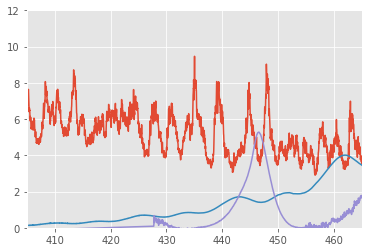

In [65]:
from hapi import *

HAPI version: 1.1.0.8.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [66]:
# Get O2 cross sections between 1-3 wavenumbers.
fetch('h2o',1,1,1e7/500,1e7/350)


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: h2o
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
Header written to ./h2o.header
END DOWNLOAD
                     Lines parsed: 3084
PROCESSED


In [67]:
nu_, cs_h2o_1000hPa = absorptionCoefficient_Voigt(SourceTables='h2o', WavenumberRange=[1e7/500,1e7/350],Environment={'p':1,'T':293},WavenumberStep=0.01,WavenumberWing=40)

In [92]:
f = interp1d(1.e7/nu_, cs_h2o_1000hPa)
wl = np.arange(400,470,0.01)
cs_h2o = f(wl)
h2o = np.zeros((len(cs_h2o),2))
h2o[:,0]=wl_h2o
h2o[:,1]=cs_h2o

(0, 12)

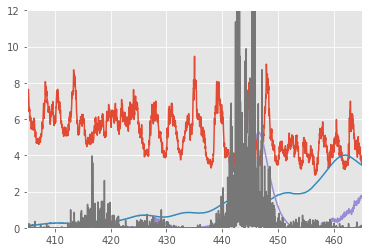

In [74]:
plt.plot(no2[:,0], no2[:,1]*1e19)
plt.plot(o3[:,0], o3[:,1]*1e22)
plt.plot(o4[:,0], o4[:,1]*1e47)
plt.plot(h2o[:,0],h2o[:,1]*1e26)
plt.xlim((405,465))
plt.ylim((0,12))

In [93]:
def convolveTROPOMI(cs, FWHM):
    wl = np.arange(400,470,0.01)
    f = interp1d(cs[:,0], cs[:,1])
    co = 2.355
    cs_conv =  gaussian_filter1d(f(wl), FWHM/0.01/co)
    return cs_conv

(0, 10)

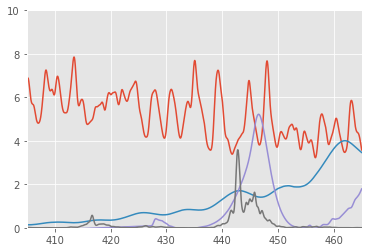

In [97]:
fwhm = 0.5
plt.plot(wl, convolveTROPOMI(no2,fwhm)*1e19)
plt.plot(wl, convolveTROPOMI(o3,fwhm)*1e22)
plt.plot(wl, convolveTROPOMI(o4,fwhm)*1e47)
plt.plot(wl, convolveTROPOMI(h2o,fwhm)*1e26)
plt.xlim((405,465))
plt.ylim((0,10))

(405, 465)

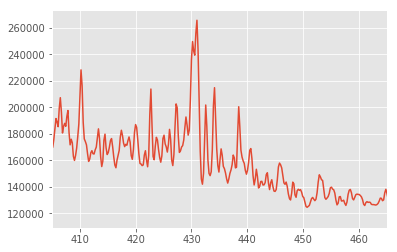

In [99]:
# Ring
plt.plot(wl_solar[fp,:], 1/spec_solar[fp,:])
plt.xlim((405,465))

In [116]:
wl_trop = wl_spec[fp,30:330]

fno2 = interp1d(wl, convolveTROPOMI(no2,fwhm))
fo3 = interp1d(wl, convolveTROPOMI(o3,fwhm))
fo4 = interp1d(wl, convolveTROPOMI(o4,fwhm))
fh2o = interp1d(wl, convolveTROPOMI(h2o,fwhm))

In [146]:
K = np.array([-fno2(wl_trop),-fo3(wl_trop),-fo4(wl_trop), -1/spec_solar[fp,30:330],-fh2o(wl_trop), np.ones(len(wl_trop)), (wl_trop-440), (wl_trop-440)**2, (wl_trop-440)**3]).T

In [147]:

print(K.shape)

(300, 9)


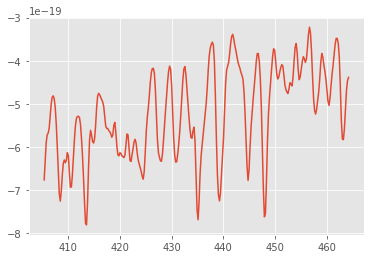

In [131]:
plt.plot(wl_trop, K[:,0])

In [148]:
gain = np.linalg.inv(K.T.dot(K)).dot(K.T)

In [204]:
so = 610
y = np.log(spec[so,fp,30:330]/spl(wl_solar[fp,30:330]+0.01))
sv = gain.dot(y)

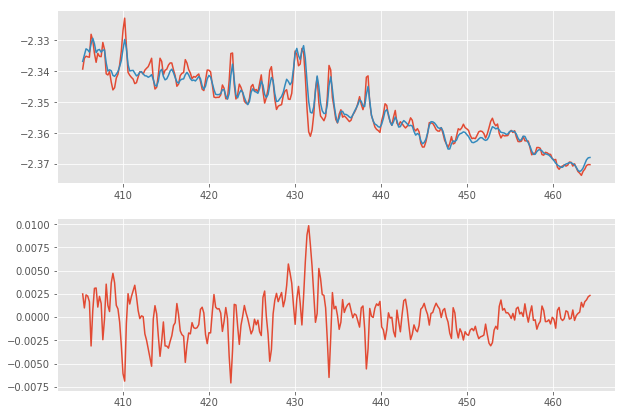

In [205]:
plt.subplot(211)
plt.plot(wl_trop, y,wl_trop, K.dot(sv) )
plt.subplot(212)
plt.plot(wl_trop, K.dot(sv)-y )

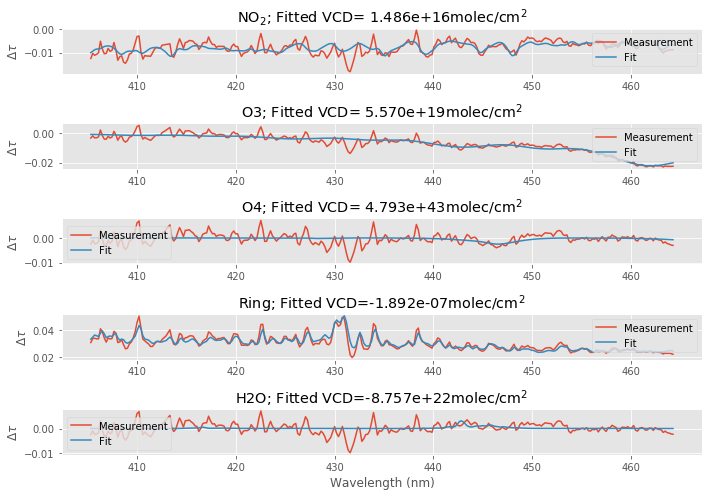

In [206]:
figsize(10,7)
leg = ['NO$_2$','O3','O4','Ring','H2O']

# Just use the Trace gases here, not the polynomial coefficients
for i in range(5):
    sv_copy = sv.copy()
    sv_copy[i]=0
    
    plt.subplot(5,1,i+1)
    plt.title(leg[i]+'; Fitted VCD='+ "%10.3e"% (sv[i])+ 'molec/cm$^2$')
    plt.plot(wl_trop, y-K.dot(sv_copy), wl_trop, K.dot(sv-sv_copy) )
    plt.ylabel(r'$\Delta \tau$')
    plt.legend(['Measurement','Fit'], loc=0)
plt.xlabel('Wavelength (nm)')
plt.tight_layout()

In [182]:
spec.shape

(2906, 450, 497)

In [183]:
notro = np.zeros((2900,))
for i in range(2900):
    so = i
    y = np.log(spec[so,fp,30:330]/spl(wl_solar[fp,30:330]-0.011))
    sv = gain.dot(y)
    notro[i]=sv[0]

/Users/cfranken/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


(400, 750)

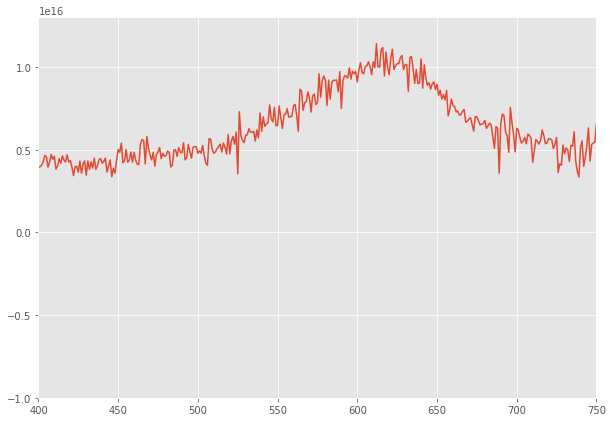

In [192]:
plt.plot(notro)
plt.ylim((-0.1e17,1.3e16))
plt.xlim((400,750))